In [4]:
import warnings, numpy as np, pandas as pd
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
import subprocess
import sys
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_fscore_support, classification_report
)

warnings.filterwarnings("ignore")

In [ ]:
# Importando datos

ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data" / "raw"
assert DATA_DIR.exists(), f"No existe la carpeta {DATA_DIR}. Crea data/raw y coloca el Excel allí."

cands = list(DATA_DIR.glob("Online*Retail*.xls*"))
if not cands:
    raise FileNotFoundError(
        "No se encontró ningún archivo tipo 'Online*Retail*.xls*' en data/raw.\n"
        "Asegúrate de copiar el archivo (por ej. 'Online Retail.xlsx') a data/raw."
    )
fp = cands[0]
print(f"Archivo detectado: {fp}")

# ---- Lectura robusta (instala openpyxl si hace falta para .xlsx) ----
def read_excel_safely(path: Path) -> pd.DataFrame:
    if path.suffix.lower() == ".xlsx":
        try:
            import openpyxl  # noqa
        except ImportError:
            print("Instalando 'openpyxl' para leer .xlsx…")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "openpyxl"])
    return pd.read_excel(path)

df = read_excel_safely(fp)

Archivo detectado: c:\Users\gabri\OneDrive\ProyectoFinalMLOps\data\raw\Online Retail.xlsx


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cust

In [7]:

df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Filtrado básico para el MVP de recompra
df = df[(df["UnitPrice"] > 0) & (df["Quantity"] > 0)]
df = df[~df["InvoiceNo"].str.startswith("C")]      # quita devoluciones/cancelaciones
df = df.dropna(subset=["CustomerID"]).copy()
df["CustomerID"] = df["CustomerID"].astype(int)

df["Revenue"] = df["Quantity"] * df["UnitPrice"]
df.shape, df["CustomerID"].nunique(), df["StockCode"].nunique()

((397884, 9), 4338, 3665)

In [8]:
# 01 - Métricas rápidas
print("Fecha mínima:", df["InvoiceDate"].min())
print("Fecha máxima:", df["InvoiceDate"].max())
print("Clientes únicos:", df["CustomerID"].nunique())
print("SKUs únicos:", df["StockCode"].nunique())
print("Países:", df["Country"].nunique())

# Ventas por día
daily = df.set_index("InvoiceDate").resample("D")["Revenue"].sum().reset_index()
daily.head()

Fecha mínima: 2010-12-01 08:26:00
Fecha máxima: 2011-12-09 12:50:00
Clientes únicos: 4338
SKUs únicos: 3665
Países: 37


,InvoiceDate,Revenue
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-04,0.00
4,2010-12-05,31771.60


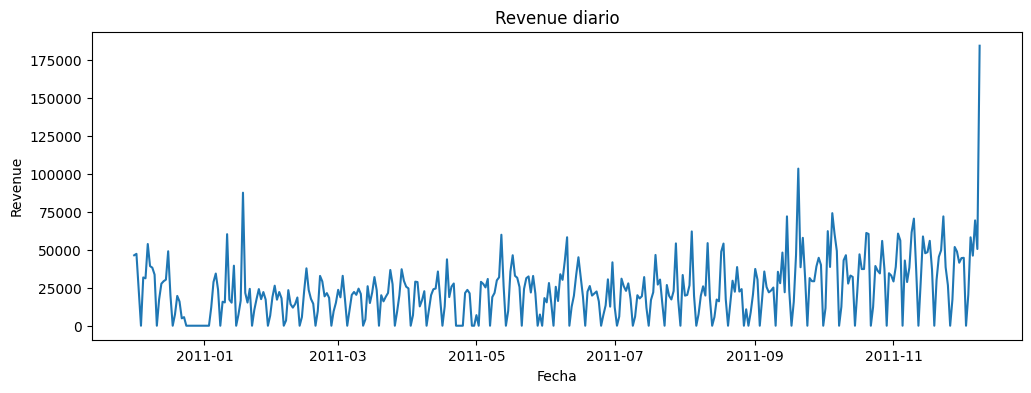

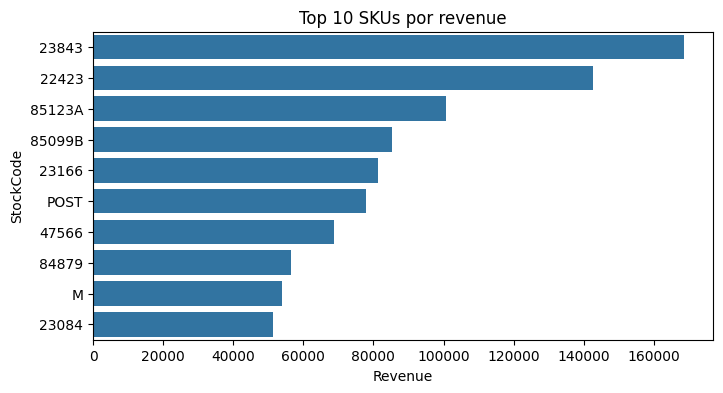

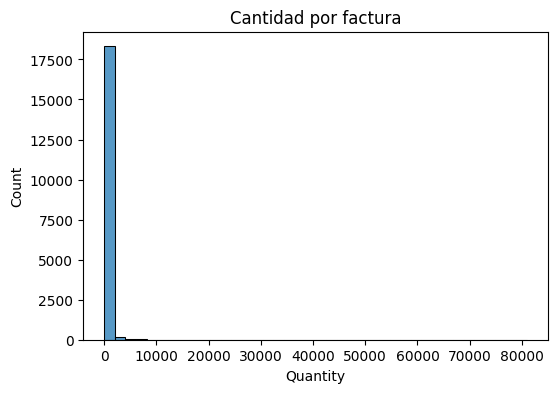

In [9]:
# 02 - Gráficos básicos (matplotlib / seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

# Serie de ventas diarias
plt.figure(figsize=(12,4))
plt.plot(daily["InvoiceDate"], daily["Revenue"])
plt.title("Revenue diario")
plt.xlabel("Fecha"); plt.ylabel("Revenue")
plt.show()

# Top 10 productos por revenue
top_skus = (df.groupby("StockCode")["Revenue"].sum()
              .sort_values(ascending=False).head(10).reset_index())

plt.figure(figsize=(8,4))
sns.barplot(data=top_skus, x="Revenue", y="StockCode")
plt.title("Top 10 SKUs por revenue")
plt.show()

# Distribución de cantidad por factura
qty_per_invoice = df.groupby("InvoiceNo")["Quantity"].sum()
plt.figure(figsize=(6,4))
sns.histplot(qty_per_invoice, bins=40)
plt.title("Cantidad por factura")
plt.show()

In [10]:
# 03 - RFM por cliente (base para el modelo de recompra)
import numpy as np
cutoff = df["InvoiceDate"].max()  
rfm = (df.groupby("CustomerID")
         .agg(last_date=("InvoiceDate", "max"),
              frequency=("InvoiceNo", "nunique"),
              monetary=("Revenue", "sum"))
         .reset_index())
rfm["recency_days"] = (cutoff - rfm["last_date"]).dt.days
rfm.drop(columns=["last_date"], inplace=True)
rfm.describe()

,CustomerID,frequency,monetary,recency_days
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,4.272015,2054.266460,91.536422
std,1721.808492,7.697998,8989.230441,100.014169
min,12346.000000,1.000000,3.750000,0.000000
25%,13813.250000,1.000000,307.415000,17.000000
50%,15299.500000,2.000000,674.485000,50.000000
75%,16778.750000,5.000000,1661.740000,141.000000
max,18287.000000,209.000000,280206.020000,373.000000
